# Question 1: Download dataset and plot each class figure

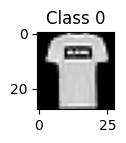

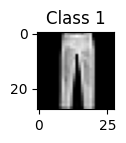

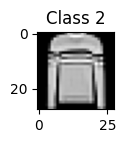

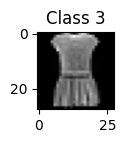

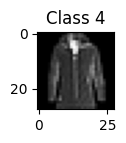

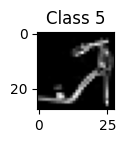

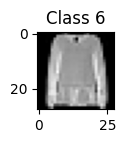

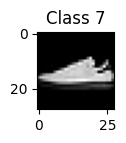

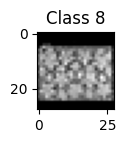

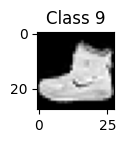

In [56]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


(x_train,y_train),(x_test,y_test)= fashion_mnist.load_data()
x_train=x_train/255
x_test=x_test/255





for i in range(10):
    plt.figure(figsize=(1, 1))

    # Find the index of the first image with the current class label
    # np.where returns many tuples where y_train==i from this choose first tuple then from this tuple first element
    # so np.where(y_train == i)[0][0] will retun index

    index = np.where(y_train == i)[0][0]

    # Plot the sample image

    plt.imshow(x_train[index],cmap='gray')
    plt.title("Class " + str(i))
    plt.show()



# Question 2: Feedforward Nueral Network

In [57]:
# Choose number of layer
num_layers= 3

# Choose number of nuerons per each layer
num_neurons= 64

num_classes =10


X = x_train

# Reshaping (60000,28,28) to (60000,784)
X = X.reshape(X.shape[0], -1)


n_features=X.shape[1]

In [58]:
def randomweightsandbias(num_layers,num_neurons,n_features):
    # Initialize Random weights and biases

    # These are W[0] and b[0] which are not in use

    W = [np.random.randn(num_neurons,n_features)]
    b = [np.zeros((num_neurons,1))]

    # Here initializing W[1] and b[1]

    W.append(np.random.randn(num_neurons,n_features))  # Weight matrix for input layer
    b.append(np.zeros((num_neurons,1)))# Bias vector for input layer

    # Initializing intermidiate W and b

    for _ in range(num_layers - 2):
      W.append(np.random.randn(num_neurons, num_neurons))
      b.append(np.zeros((num_neurons,1)))

    # Initializing output layer W and b

    W.append(np.random.randn(num_classes,num_neurons))  # Weight matrix for output layer
    b.append(np.zeros((num_classes,1)))  # Bias vector for output layer

    return W,b

def xavier_init_weights(n_in, n_out):
    limit = np.sqrt(6.0 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=(n_in, n_out))

def xavier_init_bias(n_out):
    limit = np.sqrt(6.0 / n_out)
    return np.random.uniform(-limit, limit, size=(n_out, 1))

def xaviorweightsandbias(num_layers,num_neurons,n_features):


    # These are W[0] and b[0] which are not in use

    W = [xavier_init_weights(num_neurons,n_features)]
    b = [xavier_init_bias(num_neurons)]

    # Here initializing W[1] and b[1]

    W.append(xavier_init_weights(num_neurons,n_features))  # Weight matrix for input layer
    b.append(xavier_init_bias(num_neurons))# Bias vector for input layer

    # Initializing intermidiate W and b

    for _ in range(num_layers - 2):
      W.append(xavier_init_weights(num_neurons, num_neurons))
      b.append(xavier_init_bias(num_neurons))

    # Initializing output layer W and b

    W.append(xavier_init_weights(num_classes,num_neurons))  # Weight matrix for output layer
    b.append(xavier_init_bias(num_classes))  # Bias vector for output layer


    return W,b


In [59]:
def initializeWeightandbias(initialize_method,num_layers,num_neurons,n_features):

    if(initialize_method==1):
      return randomweightsandbias(num_layers,num_neurons,n_features)

    elif(initialize_method==2):
       return xaviorweightsandbias(num_layers,num_neurons,n_features)


#Weights and bias initialization

#1 for random initialization
#2 for xavior initialization

initialize_method =1

W,b = initializeWeightandbias(initialize_method,num_layers,num_neurons,n_features)



In [60]:
def sigmoid(data1):

  # As for high values or low values of data1 issue of overflow so to overcome that used clip

  sigmoid_x = 1 /(1+ np.exp(np.clip(-data1, -400, 400)))

  return sigmoid_x


def relu(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


def softmax(data2):
    e_x =  np.exp(np.clip(data2, -400, 400))
    return e_x / np.sum(e_x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


def sigmoid_derivative(x):

  sigmoid_x = 1 /(1+ np.exp(np.clip(-x, -400, 400)))
  return sigmoid_x * (1 - sigmoid_x)



def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def one_hot_encoding(y):
    encoded = np.zeros((num_classes,1))
    encoded[y] = 1

    return encoded

In [61]:
def feedforwardnn(data,num_layers,num_neurons,W,b,activation_function):


  n_features =len(data)

  a=[]
  h=[]

  a.append(data)
  h.append(data)




  for k in range(1, num_layers):

    a.append(b[k] + (W[k] @ h[k-1]))



    if(activation_function=="ReLU"):
      h.append(relu(a[k]))
    if(activation_function=="sigmoid"):
      h.append(sigmoid(a[k]))
    if(activation_function=="tanh"):
      h.append(tanh(a[k]))




  a.append(b[num_layers] + (W[num_layers] @ h[num_layers-1]))







  probability_distribution=(softmax(a[num_layers]))



  return a,h,probability_distribution


In [62]:
#Checking for first data point
a,h,y_hat=feedforwardnn(X[0].reshape(784,1),num_layers,num_neurons,W,b,"ReLU")
print(y_hat)


[[0.00000000e+000]
 [1.62323070e-109]
 [2.42088555e-253]
 [1.68851338e-213]
 [0.00000000e+000]
 [5.00000000e-001]
 [4.94398619e-212]
 [5.00000000e-001]
 [1.69236315e-272]
 [9.27866001e-119]]


In [63]:
X.shape

(60000, 784)

In [64]:
for i in range(len(W)):
   print((W[i].shape))

(64, 784)
(64, 784)
(64, 64)
(10, 64)


# Question 3: Backpropogation

In [65]:
def backward_propagation(inputs,h,a,W,actual_y,predicted_y,activation_function):

    grad_with_a=[np.zeros_like(a[i]) for i in range(num_layers + 1)]
    grad_with_w=[np.zeros_like(W[i]) for i in range(num_layers + 1)]
    #q=[np.zeros_like(W[i]) for i in range(num_layers + 1)]
    grad_with_b=[np.zeros_like(b[i]) for i in range(num_layers + 1)]



    grad_with_h=[np.zeros_like(h[i]) for i in range(num_layers )]
    grad_with_h[0]=inputs

    y_encoded =  one_hot_encoding(actual_y)

    grad_with_a[num_layers] = (predicted_y-y_encoded )







    for k in range(num_layers, 0, -1):



        # Compute gradiant with respect to parameters



        grad_with_w[k]=(grad_with_a[k] @ (h[k-1].T))




        grad_with_b[k]=grad_with_a[k]

        # Compute gradian with respect to layer below

        grad_with_h[k-1] = W[k].T @ grad_with_a[k]

        # Compute gradian with respect to layer below (Pre activation)

        if(activation_function=="ReLU"):

          grad_with_a[k-1] = grad_with_h[k-1] * relu_derivative(a[k-1])

        elif(activation_function=="sigmoid"):

          grad_with_a[k-1] = grad_with_h[k-1] * sigmoid_derivative(a[k-1])

        elif(activation_function=="tanh"):

          grad_with_a[k-1] = grad_with_h[k-1] * tanh_derivative(a[k-1])




    return grad_with_w, grad_with_b




grad_with_w, grad_with_b= backward_propagation(X[0].reshape(784,1),h,a,W,y_train[0],y_hat,"ReLU")

In [66]:
def LossAccuracy(W,b) :
     # For Training error

    #Initial loss is 0
    Loss_train = 0
    MSE_train = 0

    count_training=0

    for x,y in zip(X[:54000], y_train[:54000]):

      a,h,y_hat_training=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)

      y_predicted=np.argmax(y_hat_training)

      if(y==y_predicted):
        count_training += 1


      # Finding loss :

      Loss_train = Loss_train + -np.log(np.clip(y_hat_training[y], 1e-6, 400))

      # Finding Mean Squared Error:

      #making y_true one hot coded
      y_true=np.zeros((num_classes))
      y_true[y]=1

      MSE_train= MSE_train + np.mean((y_true - y_hat_training) ** 2)

    Training_Accuracy = count_training / 54000
    print(f'Training Accuracy : {Training_Accuracy}')

    Loss_train = Loss_train / 54000
    print(f'Training Loss : {Loss_train}')

    MSE_train = MSE_train / 54000
    print(f'Training Mean squared error : {MSE_train}')









    # For validation error

    #Initial loss is 0
    Loss_val = 0
    MSE_val = 0

    count_validation=0
    for x,y in zip(X[54000:], y_train[54000:]):

      a,h,y_hat_validation=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)

      y_predicted=np.argmax(y_hat_validation)

      if(y==y_predicted):
        count_validation += 1

      # Finding loss :

      Loss_val = Loss_val + -np.log(y_hat_validation[y])

      # Finding Mean Squared Error:

      #making y_true one hot coded
      y_true=np.zeros((num_classes))
      y_true[y]=1

      MSE_val= MSE_val + np.mean((y_true - y_hat_validation) ** 2)



    Validation_Accuracy = count_validation / 6000
    print(f'Validation Accuracy : {Validation_Accuracy}')

    Loss_val = Loss_val / 6000
    print(f'Validation Loss : {Loss_val}')

    MSE_val = MSE_val / 6000
    print(f'Validation Mean squared error : {MSE_val}')
    print("\n")



# Simple Gradient Descent:

In [67]:
def Gradient_descent(x_train,y_train,max_epochs,batch_size,W,b):

  d=batch_size

  X = x_train.reshape(x_train.shape[0], -1)




  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))

    for x,y in zip(X[:54000], y_train[:54000]):

        if(d==batch_size):
          dw = [np.zeros_like(w) for w in W]
          db = [np.zeros_like(c) for c in b]

        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):

          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

        d=d-1

        if(d==0):

          for j in range(num_layers+1):
            #print(eta * dw[j])

            W[j] = np.subtract(W[j] , eta * dw[j])

            b[j] = np.subtract(b[j] , eta * db[j])

          d=batch_size

    # For accuracy loss and MSE

    LossAccuracy(W,b)


  return W,b

# Stochastic Gradient Descent:

In [68]:
def Stochastic_Gradient_descent(x_train,y_train,max_epochs,batch_size,W,b):

  d=batch_size

  X = x_train.reshape(x_train.shape[0], -1)



  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))



    for x,y in zip(X[:54000], y_train[:54000]):

        dw = [np.zeros_like(w) for w in W]
        db = [np.zeros_like(c) for c in b]


        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):

          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

          W[i] = np.subtract(W[i] , eta * dw[i])

          b[i] = np.subtract(b[i] , eta * db[i])


    # For accuracy loss and MSE

    LossAccuracy(W,b)

  return W,b




# Momentum based gradient descent:

In [69]:
def Momentum_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta,W,b):

  d=batch_size

  X = x_train.reshape(x_train.shape[0], -1)


  prev_uw = [np.zeros_like(w) for w in W]
  prev_ub = [np.zeros_like(c) for c in b]

  uw = [np.zeros_like(w) for w in W]
  ub = [np.zeros_like(c) for c in b]



  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))



    for x,y in zip(X[:54000], y_train[:54000]):

        if(d==batch_size):
          dw = [np.zeros_like(w) for w in W]
          db = [np.zeros_like(c) for c in b]

        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):
          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

        d=d-1

        if(d==0):



          for j in range(num_layers+1):

            uw[j] = beta * prev_uw[j] + eta * dw[j]
            ub[j] = beta * prev_ub[j] + eta * db[j]

            W[j] = (W[j] - eta * uw[j])

            b[j] = (b[j] - eta * ub[j])

            prev_uw[j] = uw[j]

            prev_ub[j] = ub[j]

          d=batch_size

    # For accuracy loss and MSE

    LossAccuracy(W,b)

  return W,b

# Nesterov accelerated gradient descent:

In [70]:
def Nesterov_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta,W,b):

  d=batch_size



  X = x_train.reshape(x_train.shape[0], -1)

  prev_vw = [np.zeros_like(w) for w in W]
  prev_vb = [np.zeros_like(c) for c in b]

  vw = [np.zeros_like(w) for w in W]
  vb = [np.zeros_like(c) for c in b]

  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))


    for j in range(num_layers+1):
      vw[j] = beta * prev_vw[j]
      vb[j] = beta * prev_vb[j]

    for x,y in zip(X[:54000], y_train[:54000]):

        if(d==batch_size):
          dw = [np.zeros_like(w) for w in W]
          db = [np.zeros_like(c) for c in b]
          for j in range(num_layers+1):
            vw[j] = beta * prev_vw[j]
            vb[j] = beta * prev_vb[j]
          for j in range(num_layers+1):
            W[j] = W[j] - vw[j]
            b[j] = b[j] - vb[j]

        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):
          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

        d=d-1

        if(d==0):



          for j in range(num_layers+1):

            vw[j] = beta * prev_vw[j] + eta * dw[j]
            vb[j] = beta * prev_vb[j] + eta * db[j]

            W[j] = (W[j] - eta * vw[j])
            #print((W[j] - eta * dw[j]))

            b[j] = (b[j] - eta * vb[j])

            prev_vw[j] = vw[j]

            prev_vb[j] = vb[j]

          d=batch_size

    # For accuracy loss and MSE

    LossAccuracy(W,b)

  return W,b

# Rmsprop gradient descent

In [84]:
def Rmsprop_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta,eps,W,b):

  d=batch_size



  X = x_train.reshape(x_train.shape[0], -1)


  vw = [np.zeros_like(w) for w in W]
  vb = [np.zeros_like(c) for c in b]

  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))


    for x,y in zip(X[:54000], y_train[:54000]):

        if(d==batch_size):
          dw = [np.zeros_like(w) for w in W]
          db = [np.zeros_like(c) for c in b]


        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):
          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

        d=d-1

        if(d==0):



          for j in range(num_layers+1):

            vw[j] = beta * vw[j] + (1-beta) * (dw[j]**2)
            vb[j] = beta * vb[j] + (1-beta) * (db[j]**2)

            W[j] = (W[j] - (eta * dw[j]/(np.sqrt(vw[j])+eps)))


            b[j] = (b[j] - (eta * db[j]/(np.sqrt(vb[j])+eps)))



          d=batch_size

    # For accuracy loss and MSE

    LossAccuracy(W,b)

  return W,b

# Adam gradient descent :

In [78]:
def Adam_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta1,beta2,eps,W,b):

  d=batch_size



  X = x_train.reshape(x_train.shape[0], -1)

  mw = [np.zeros_like(w) for w in W]
  mb = [np.zeros_like(c) for c in b]

  mw_hat = [np.zeros_like(w) for w in W]
  mb_hat = [np.zeros_like(c) for c in b]

  vw = [np.zeros_like(w) for w in W]
  vb = [np.zeros_like(c) for c in b]

  vw_hat = [np.zeros_like(w) for w in W]
  vb_hat = [np.zeros_like(c) for c in b]

  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))




    for x,y in zip(X[:54000], y_train[:54000]):

        if(d==batch_size):
          dw = [np.zeros_like(w) for w in W]
          db = [np.zeros_like(c) for c in b]


        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):
          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

        d=d-1

        if(d==0):



          for j in range(num_layers+1):

            mw[j] = beta1 * mw[j] + (1-beta1) * dw[j]
            mb[j] = beta1 * mb[j] + (1-beta1) * db[j]
            vw[j] = beta2 * vw[j] + (1-beta2) * (dw[j]**2)
            vb[j] = beta2 * vb[j] + (1-beta2) * (db[j]**2)

            mw_hat[j] = mw[j] / (1-np.power(beta1,i+1))
            mb_hat[j] = mb[j] / (1-np.power(beta1,i+1))
            vw_hat[j] = vw[j] / (1-np.power(beta2,i+1))
            vb_hat[j] = vb[j] / (1-np.power(beta2,i+1))

            W[j] = (W[j] -(eta * mw_hat[j]/(np.sqrt(vw_hat[j])+eps)))


            b[j] = (b[j] -(eta * mb_hat[j]/(np.sqrt(vb_hat[j])+eps)))


          d=batch_size

    # For accuracy loss and MSE

    LossAccuracy(W,b)

  return W,b

# Nadam gradient descent:

In [80]:
def Nadam_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta1,beta2,eps,W,b):

  d=batch_size



  X = x_train.reshape(x_train.shape[0], -1)

  mw = [np.zeros_like(w) for w in W]
  mb = [np.zeros_like(c) for c in b]

  mw_hat = [np.zeros_like(w) for w in W]
  mb_hat = [np.zeros_like(c) for c in b]

  vw = [np.zeros_like(w) for w in W]
  vb = [np.zeros_like(c) for c in b]

  vw_hat = [np.zeros_like(w) for w in W]
  vb_hat = [np.zeros_like(c) for c in b]

  for i in (range(max_epochs)):
    print("Epoch: %d\n"%(i+1))




    for x,y in zip(X[:54000], y_train[:54000]):

        if(d==batch_size):
          dw = [np.zeros_like(w) for w in W]
          db = [np.zeros_like(c) for c in b]


        a,h,y_hat=feedforwardnn(x.reshape(784,1),num_layers,num_neurons,W,b,activation_function)
        grad_with_w, grad_with_b = backward_propagation(x.reshape(784,1),h,a,W,y,y_hat,activation_function)

        for i in range(num_layers+1):
          dw[i] = np.add(dw[i],grad_with_w[i])
          db[i] = np.add(db[i],grad_with_b[i])

        d=d-1

        if(d==0):



          for j in range(num_layers+1):

            mw[j] = beta1 * mw[j] + (1-beta1) * dw[j]
            mb[j] = beta1 * mb[j] + (1-beta1) * db[j]
            vw[j] = beta2 * vw[j] + (1-beta2) * (dw[j]**2)
            vb[j] = beta2 * vb[j] + (1-beta2) * (db[j]**2)

            mw_hat[j] = mw[j] / (1-np.power(beta1,i+1))
            mb_hat[j] = mb[j] / (1-np.power(beta1,i+1))
            vw_hat[j] = vw[j] / (1-np.power(beta2,i+1))
            vb_hat[j] = vb[j] / (1-np.power(beta2,i+1))

            W[j] = (W[j] -(eta /(np.sqrt(vw_hat[j])+eps)) * (beta1 * mw_hat[j] + (1-beta1)*dw[j]/(1-beta1**(i+1))))


            b[j] = (b[j] -(eta/(np.sqrt(vb_hat[j])+eps)) * (beta1 * mb_hat[j] + (1-beta1)*db[j]/(1-beta1**(i+1))))


          d=batch_size

    # For accuracy loss and MSE

    LossAccuracy(W,b)

  return W,b

# Main Function calling methods:

In [85]:
# Choose number of hidden layer
num_hidden_layers = 2

num_layers = num_hidden_layers + 1

# Choose number of nuerons per each hidden layer
num_neurons= 64

# Choose activation funtion



activation_function = "sigmoid"

#Weights and bias initialization

#1 for random initialization
#2 for xavior initialization

initialize_method =1

W,b = initializeWeightandbias(initialize_method,num_layers,num_neurons,n_features)

max_epochs=5
batch_size=32



eta=0.01


#For Momentum Gradient Descent
beta=0.9
beta1=0.9
beta2 = 0.999

eps = 1e-4

prev_vw = [np.zeros_like(w) for w in W]
prev_vb = [np.zeros_like(c) for c in b]

vw = [np.zeros_like(w) for w in W]
vb = [np.zeros_like(c) for c in b]

# Choose Gradient descent method

# 0 for simple Gradient descent
# 1 for stochastic Gradient descent
# 2 for momentum based gradient descent
# 3 for nesterov accelerated gradient descent
# 4 for rmsprop
# 5 for adam
# 6 for nadam

Gradient_descent_method = 4


if(Gradient_descent_method==0):
  W, b = Gradient_descent(x_train,y_train,max_epochs,batch_size,W,b)
elif(Gradient_descent_method==1):
  W, b = Stochastic_Gradient_descent(x_train,y_train,max_epochs,batch_size,W,b)
elif(Gradient_descent_method==2):
  W, b = Momentum_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta,W,b)
elif(Gradient_descent_method==3):
  W, b = Nesterov_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta,W,b)
elif(Gradient_descent_method==4):
  W, b = Rmsprop_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta,eps,W,b)
elif(Gradient_descent_method==5):
  W, b = Adam_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta1,beta2,eps,W,b)
elif(Gradient_descent_method==6):
  W, b = Nadam_Gradient_descent(x_train,y_train,max_epochs,batch_size,beta1,beta2,eps,W,b)





Epoch: 1

Training Accuracy : 0.8254814814814815
Training Loss : [0.48389274]
Training Mean squared error : 0.157907979437618
Validation Accuracy : 0.8123333333333334
Validation Loss : [0.51188602]
Validation Mean squared error : 0.15762937484000217


Epoch: 2

Training Accuracy : 0.8233148148148148
Training Loss : [0.49911039]
Training Mean squared error : 0.15879297538420611
Validation Accuracy : 0.8118333333333333
Validation Loss : [0.53376983]
Validation Mean squared error : 0.1584242176099785


Epoch: 3

Training Accuracy : 0.8432407407407407
Training Loss : [0.44236267]
Training Mean squared error : 0.1585822634414722
Validation Accuracy : 0.8351666666666666
Validation Loss : [0.47842947]
Validation Mean squared error : 0.1585583837542207


Epoch: 4

Training Accuracy : 0.8507592592592592
Training Loss : [0.4230829]
Training Mean squared error : 0.16090512031408027
Validation Accuracy : 0.8413333333333334
Validation Loss : [0.46394592]
Validation Mean squared error : 0.1607788974